In [1]:
from pyresample.ewa import DaskEWAResampler
import xarray as xr
from pyresample.bilinear import XArrayBilinearResampler
from datetime import datetime
import numpy as np
import xarray as xr
import pyproj
from pyresample.geometry import SwathDefinition
import pyresample.kd_tree as kd_tree
from pyresample import get_area_def
from Preprocessing_pipeline import generate_filename_dict

class ProjectionTransformer():
    def generate_lat_lon_prj(self, aux_data):
        # Import lat and longitude matrixes taht indicate the corresponding latitude and longitude of each data within the field
        lon_mat, lat_mat = aux_data["lon"][0, :, :], aux_data["lat"][0, :, :]

        # Generate variables needed for the later reshaping of the data
        self.bounds = [np.nanmin(lon_mat.astype(np.float64)), np.nanmax(lon_mat.astype(
            np.float64)), np.nanmin(lat_mat.astype(np.float64)), np.nanmax(lat_mat.astype(np.float64))]
        print(f"Bounds = {self.bounds}")
        Proj4Args = '+proj=eqc +lat_ts=0 +lat_0=0 +lon_0=0 +x_0=0 +y_0=0 +a=6378.137 +b=6378.137 +units=km'
        Prj = pyproj.Proj(Proj4Args)
        AreaID = 'cyl'
        AreaName = 'cyl'
        ProjID = 'cyl'
        # print(np.nanmin(lon_mat.astype(np.float64)),np.nanmin(lat_mat.astype(np.float64)))
        self.ny, self.nx = lon_mat.shape
        # Get the projected poisions of the mst South West and North ast points: Usually outputs sth in the range 5-15
        # I have no idea how it works acually but it works so I wont question it
        SW = Prj(self.bounds[0], self.bounds[2])
        NW = Prj(self.bounds[1], self.bounds[3])
        area_extent = [SW[0], SW[1], NW[0], NW[1]]
        # print(area_extent)
        # The transformation in remap_data transforms th data from SwathDef to AreaDef
        self.AreaDef = get_area_def(
            AreaID, AreaName, ProjID, Proj4Args, self.nx, self.ny, area_extent)
        self.SwathDef = SwathDefinition(lons=lon_mat, lats=lat_mat)

        self.generate_new_coordinates()

    def generate_new_coordinates(self):
        self.new_cord_lon = np.linspace(
            self.bounds[0], self.bounds[1], self.nx)
        self.new_cord_lat = np.linspace(
            self.bounds[2], self.bounds[3], self.ny)

    def remap_data(self, var_field, n_resample_procs=4):
        # Satellite height
        if self.SwathDef == None:
            raise Exception(
                "Error: No projection parameters generated. To generate run Projection_transformer_instance.generate_lat_lon_prj().")
        output_field = np.empty(var_field.shape)
        if len(var_field.shape) == 3:
            output_field = kd_tree.resample_nearest(self.SwathDef, var_field.transpose("y", "x", "time").values, self.AreaDef, radius_of_influence=60000,
                                                    fill_value=-1, epsilon=5, nprocs=n_resample_procs)  # reduce_data=True
            output_field = output_field.transpose(2, 0, 1)
            output_field = np.flip(output_field,1)
            output_field[np.isnan(output_field)] = -1
            return output_field
        else:
            raise NotImplementedError("2D var field remapping not yet added")

In [2]:
aux_data=xr.open_dataset("/wolke_scratch/dnikolo/CLAAS_Data/np/CM_SAF_CLAAS3_L2_AUX.nc",decode_times=False)


In [3]:
t_deltas = [5]
agg_fact = 3
target_filenames = generate_filename_dict(start_time=datetime(
    2023, 1, 16, 0, 15), end_time=datetime(2023, 1, 17, 0, 0), t_deltas=t_deltas, agg_fact=agg_fact)

In [4]:

target_fps = target_filenames["np"]["resample_CTX"]
data = xr.open_mfdataset(target_fps, parallel=True, chunks={"time":len(target_fps) , "x":aux_data.sizes["x"], "y":aux_data.sizes["y"]})

In [5]:
data['ctt'].coords

Coordinates:
  * time     (time) datetime64[ns] 768B 2023-01-16T00:15:00 ... 2023-01-17
  * x        (x) float64 25kB -0.1313 -0.1312 -0.1311 ... 0.1311 0.1312 0.1313
  * y        (y) float64 7kB 0.1513 0.1513 0.1512 ... 0.07647 0.07638 0.0763

In [6]:
transformer = ProjectionTransformer()
transformer.generate_lat_lon_prj(aux_data)

Bounds = [-79.74298161940857, 79.7396484770131, 26.044719326356088, 81.07635224475464]


In [7]:
data['ctt'].transpose("x", "y", "time")

<xarray.DataArray 'ctt' (x: 3133, y: 896, time: 96)> Size: 1GB
dask.array<transpose, shape=(3133, 896, 96), dtype=float32, chunksize=(3133, 896, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 768B 2023-01-16T00:15:00 ... 2023-01-17
  * x        (x) float64 25kB -0.1313 -0.1312 -0.1311 ... 0.1311 0.1312 0.1313
  * y        (y) float64 7kB 0.1513 0.1513 0.1512 ... 0.07647 0.07638 0.0763
Attributes:
    units:          K
    valid_range:    [   0 4060]
    standard_name:  air_temperature_at_cloud_top
    long_name:      Cloud Top Temperature
    grid_mapping:   projection
    cell_methods:   time: point

In [8]:
result=transformer.remap_data(data['ctt'])

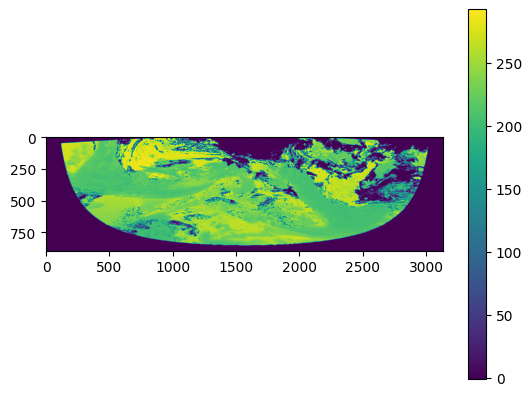

In [9]:
import matplotlib.pyplot as plt 
plt.imshow(result[0,:,:])
plt.colorbar()

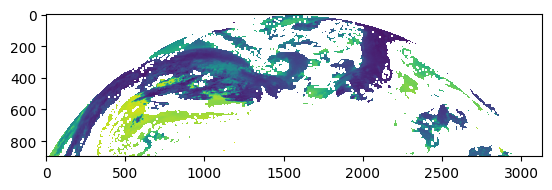

In [10]:
plt.imshow(data['ctt'].transpose("y", "x", "time")[:,:,0])

In [11]:
# resampler = DaskEWAResampler(transformer.SwathDef, transformer.AreaDef)
# data["ctt"].unstack("time",)
# result = resampler.resample(data["ctt"], rows_per_scan=1)